## Gradient Boosting for Prediction and Inference

### Lesson 4
In this lesson we will learn about how to understand and evaluate models *beyond* simple metrics of their test set performance.  We will be able to answer questions like:

1. Which variables are most important to my model *in general*?
1. What is the nature of the relationship between the predictors and the target
1. Are there significant interaction effects?
1. For a specific prediction, what were the most important reasons leading to that prediction?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
xgb.__version__

pd.options.display.max_columns = 999

## Ames Housing Data

We'll continue using the Ames housing data to start

In [2]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error 
from sklearn.metrics import log_loss, roc_auc_score, accuracy_score
from sklearn.model_selection import train_test_split

In [3]:
df_house = pd.read_csv('data/Ames_Housing_Data.tsv', delimiter='\t')
df_house = df_house.loc[df_house['Gr Liv Area']<=4000,:]
df_house['Garage Area'].fillna(0, inplace=True)
df_house.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2925 entries, 0 to 2929
Data columns (total 82 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Order            2925 non-null   int64  
 1   PID              2925 non-null   int64  
 2   MS SubClass      2925 non-null   int64  
 3   MS Zoning        2925 non-null   object 
 4   Lot Frontage     2435 non-null   float64
 5   Lot Area         2925 non-null   int64  
 6   Street           2925 non-null   object 
 7   Alley            198 non-null    object 
 8   Lot Shape        2925 non-null   object 
 9   Land Contour     2925 non-null   object 
 10  Utilities        2925 non-null   object 
 11  Lot Config       2925 non-null   object 
 12  Land Slope       2925 non-null   object 
 13  Neighborhood     2925 non-null   object 
 14  Condition 1      2925 non-null   object 
 15  Condition 2      2925 non-null   object 
 16  Bldg Type        2925 non-null   object 
 17  House Style   

In [4]:
feat_1 = ['Lot Area','Overall Qual',
       'Overall Cond', 'Year Built', 'Gr Liv Area', 
        'Full Bath', 'Half Bath', 'Bedroom AbvGr',
         'Garage Area', 'Fireplaces']


In [5]:
df_house.sample(5)

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
960,961,916382110,20,RL,79.0,14463,Pave,NaN,IR1,HLS,AllPub,Corner,Gtl,Timber,Norm,Norm,1Fam,1Story,9,5,2008,2008,Gable,CompShg,CemntBd,CmentBd,BrkFace,406.0,Ex,TA,PConc,Ex,TA,Gd,GLQ,1115.0,Unf,0.0,526.0,1641.0,GasA,Ex,Y,SBrkr,1641,0,0,1641,1.0,0.0,2,0,3,1,Ex,7,Typ,0,NaN,Attchd,2008.0,Fin,3.0,885.0,TA,TA,Y,0,95,0,0,0,0,NaN,NaN,NaN,0,1,2009,WD,Normal,316500
2251,2252,914460110,20,RL,44.0,12864,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,Mitchel,Norm,Norm,1Fam,1Story,7,5,2002,2002,Gable,CompShg,VinylSd,VinylSd,None,0.0,Gd,TA,PConc,Gd,TA,No,GLQ,1392.0,Unf,0.0,17.0,1409.0,GasA,Ex,Y,SBrkr,1409,0,0,1409,1.0,0.0,1,1,1,1,Gd,4,Typ,1,Gd,Attchd,2002.0,RFn,2.0,576.0,TA,TA,Y,0,144,0,0,145,0,NaN,NaN,NaN,0,7,2007,WD,Normal,245000
1016,1017,527301170,60,RL,46.0,20544,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,NWAmes,Norm,Norm,1Fam,2Story,7,6,1986,1991,Gable,CompShg,Plywood,Plywood,BrkFace,123.0,TA,Gd,CBlock,Gd,TA,No,Unf,0.0,Unf,0.0,791.0,791.0,GasA,Gd,Y,SBrkr,1236,857,0,2093,0.0,0.0,2,1,3,1,TA,7,Typ,1,TA,Attchd,1986.0,Fin,2.0,542.0,TA,TA,Y,364,63,0,0,0,0,NaN,MnPrv,NaN,0,11,2008,WD,Normal,215000
606,607,534400290,20,RL,85.0,9350,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,6,1961,1995,Gable,CompShg,Wd Sdng,Wd Sdng,BrkFace,217.0,TA,TA,CBlock,TA,TA,No,ALQ,310.0,BLQ,512.0,491.0,1313.0,GasA,TA,Y,SBrkr,1313,0,0,1313,1.0,0.0,1,1,3,1,Gd,6,Typ,1,TA,Attchd,1961.0,RFn,2.0,610.0,TA,TA,Y,172,28,0,0,121,0,NaN,MnPrv,NaN,0,2,2009,WD,Normal,153000
2643,2644,902109010,30,RM,70.0,5684,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Norm,Norm,1Fam,1Story,6,8,1930,2005,Hip,CompShg,Wd Sdng,Wd Sdng,None,0.0,TA,TA,BrkTil,TA,TA,No,Unf,0.0,Unf,0.0,813.0,813.0,GasA,Ex,Y,FuseA,813,0,0,813,0.0,0.0,1,0,2,1,Gd,5,Typ,0,NaN,Detchd,1932.0,Unf,1.0,270.0,Fa,Fa,N,0,113,0,0,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal,110000


In [6]:
X = df_house.iloc[:,:-1]  # everything except winner
y = df_house.SalePrice 

In [7]:
X_train_full, X_test, y_train_full, y_test = train_test_split(X,y,test_size = 400, random_state=0)

In [8]:
X.loc[:,feat_1].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2925 entries, 0 to 2929
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Lot Area       2925 non-null   int64  
 1   Overall Qual   2925 non-null   int64  
 2   Overall Cond   2925 non-null   int64  
 3   Year Built     2925 non-null   int64  
 4   Gr Liv Area    2925 non-null   int64  
 5   Full Bath      2925 non-null   int64  
 6   Half Bath      2925 non-null   int64  
 7   Bedroom AbvGr  2925 non-null   int64  
 8   Garage Area    2925 non-null   float64
 9   Fireplaces     2925 non-null   int64  
dtypes: float64(1), int64(9)
memory usage: 251.4 KB


In [9]:

X_train_1 = X_train_full.loc[:, feat_1]
y_train_1 = y_train_full
X_test_1 = X_test.loc[:, feat_1]

In [10]:
## Let's start with a random forest to set a baseline

In [11]:
rf1 = RandomForestRegressor(n_estimators=1000, n_jobs=-1)
rf1

RandomForestRegressor(n_estimators=1000, n_jobs=-1)

In [12]:
rf1.fit(X_train_1, y_train_1)

RandomForestRegressor(n_estimators=1000, n_jobs=-1)

In [13]:
preds_rf1 = rf1.predict(X_test_1)

In [14]:
np.sqrt(mean_squared_error(y_test, preds_rf1)), mean_absolute_error(y_test, preds_rf1)

(23705.22561726518, 16354.644313768036)

## ICE-Plots
Individual Conditional Expectation plots are an excellent tool to understand "what the model is thinking".

How do ICE plots work?
- Take an actual data point and see what the model predicts.
- Pick a variable and change the value of that variable (over some range of values).
- Plot the model prediction as a function of the "altered" value
- Do this for multiple points, and plot on the same graph
- Do this for all variables of interest

In [15]:
import ml_insights as mli

In [16]:
rd = mli.get_range_dict(X_train_1)
test_pts = X_test_1.sample(5, random_state=1)
rd['Lot Area'] = np.linspace(0,50000, 501)

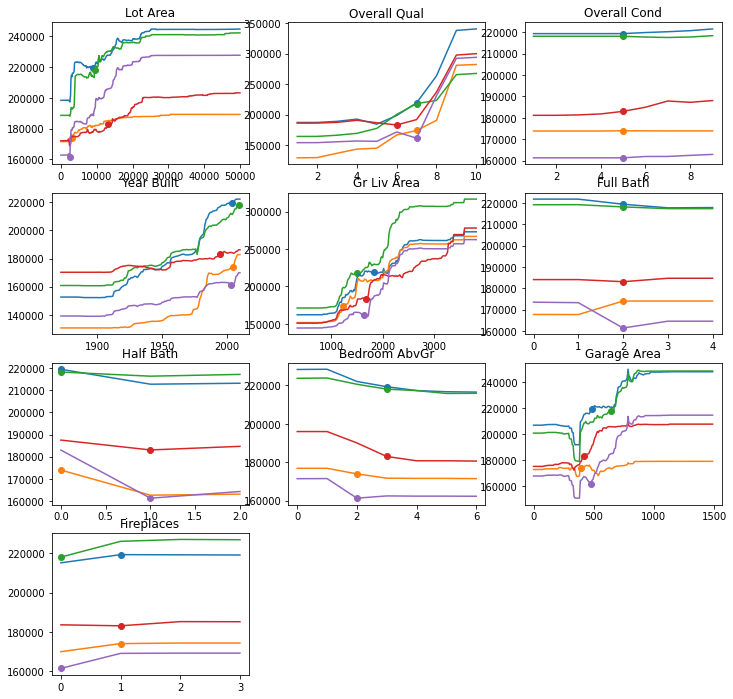

In [17]:
mli.ice_plot(rf1, test_pts, X_test_1.columns, range_pts=rd, pred_fn='predict')

## Interpreting ICE plots
Here are things you want to look for:
- When the line is flat, that means the variable is unimportant in that range (for that particular data point)
- When the line is steep, that means the variable has a strong effect on the target in that range.
- If the line is very wiggly, this often betrays some degree of "overfitting" in the model.  Interestingly, this is often *not* reflected in the test set metrics.  However, it is reflective of the "coherence" of the model.  It also may reflect a paucity of training data in that region
- If all the lines show the same basic effect, this suggests that there is little interaction.
- If some lines have very different trajectories, this indicates a high degree of interactivity.



NOTE: ICE-plots tell you what the *model* thinks.  To the extent that the model is reflective of the "real world" that generated the data, it may be useful in understanding the real world.  However, it may also be demonstrating places where the model is wrong, has little data, or is displaying artifacts of the way it was trained.  This is where our "human" thinking can be combined with the model to try and understand the world better.

### Comprehension Questions
- Which variables seem most important (globally) to the model?
- Which variables seem least important?

In [18]:
df_house.columns

Index(['Order', 'PID', 'MS SubClass', 'MS Zoning', 'Lot Frontage', 'Lot Area',
       'Street', 'Alley', 'Lot Shape', 'Land Contour', 'Utilities',
       'Lot Config', 'Land Slope', 'Neighborhood', 'Condition 1',
       'Condition 2', 'Bldg Type', 'House Style', 'Overall Qual',
       'Overall Cond', 'Year Built', 'Year Remod/Add', 'Roof Style',
       'Roof Matl', 'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type',
       'Mas Vnr Area', 'Exter Qual', 'Exter Cond', 'Foundation', 'Bsmt Qual',
       'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin SF 1',
       'BsmtFin Type 2', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF',
       'Heating', 'Heating QC', 'Central Air', 'Electrical', '1st Flr SF',
       '2nd Flr SF', 'Low Qual Fin SF', 'Gr Liv Area', 'Bsmt Full Bath',
       'Bsmt Half Bath', 'Full Bath', 'Half Bath', 'Bedroom AbvGr',
       'Kitchen AbvGr', 'Kitchen Qual', 'TotRms AbvGrd', 'Functional',
       'Fireplaces', 'Fireplace Qu', 'Garage Type', 'Garage Yr Blt',
      

In [19]:
feat_2 = ['Lot Area','Overall Qual',
       'Overall Cond', 'Year Built', 'Gr Liv Area', 
        'Full Bath', 'Half Bath', 'Bedroom AbvGr',
         'Garage Area', 'Fireplaces', 'Wood Deck SF', 'Open Porch SF']

In [20]:
X_train_2 = X_train_full.loc[:, feat_2]
y_train_2 = y_train_full
X_test_2 = X_test.loc[:, feat_2]

In [21]:
xgb_md1 = xgb.XGBRegressor(max_depth=1, 
                        n_estimators=1000, learning_rate=.05)

xgb_md1.fit(X_train_2, y_train_2, 
         eval_set=[(X_test_2, y_test)], 
        early_stopping_rounds = 10, verbose=0)

preds_xgb_md1 = xgb_md1.predict(X_test_2)

np.sqrt(mean_squared_error(y_test, preds_xgb_md1)), mean_absolute_error(y_test, preds_xgb_md1)

(23771.518363772273, 17196.326416015625)

In [22]:
xgb_md3 = xgb.XGBRegressor(max_depth=3, 
                        n_estimators=1000, learning_rate=.05)

xgb_md3.fit(X_train_2, y_train_2, 
         eval_set=[(X_test_2, y_test)], 
        early_stopping_rounds = 10, verbose=0)

preds_xgb_md3 = xgb_md3.predict(X_test_2)

np.sqrt(mean_squared_error(y_test, preds_xgb_md3)), mean_absolute_error(y_test, preds_xgb_md3)

(21592.853233305083, 15726.939287109375)

In [23]:
xgb_md6 = xgb.XGBRegressor(max_depth=6, 
                        n_estimators=1000, learning_rate=.05)

xgb_md6.fit(X_train_2, y_train_2, 
         eval_set=[(X_test_2, y_test)], 
        early_stopping_rounds = 10, verbose=0)

preds_xgb_md6 = xgb_md6.predict(X_test_2)

np.sqrt(mean_squared_error(y_test, preds_xgb_md6)), mean_absolute_error(y_test, preds_xgb_md6)

(22615.338870934087, 15843.482998046875)

In [24]:
rd2 = mli.get_range_dict(X_test_2)
rd2['Lot Area'] = np.linspace(0,50000,501)
test_pts_2 = X_test_2.sample(5, random_state=1)

## Exercise
Make ICE plots of all variables for the 3 models above.

- What differences do you notice across the 3 models?
- Compare the patterns in the following 3 variables:
    - Lot Area
    - Gr Liv Area
    - Garage Area

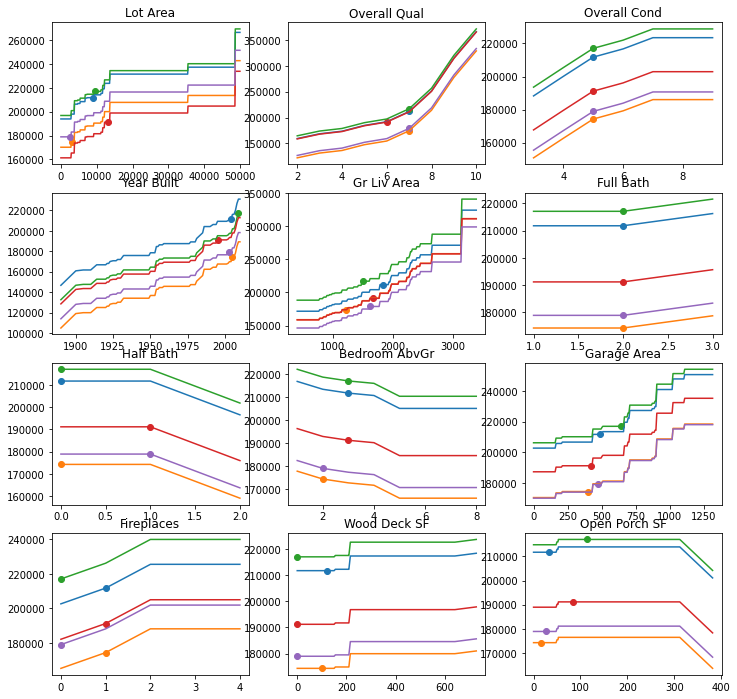

In [25]:
mli.ice_plot(xgb_md1, test_pts_2, X_test_2.columns, range_pts=rd2, pred_fn='predict')

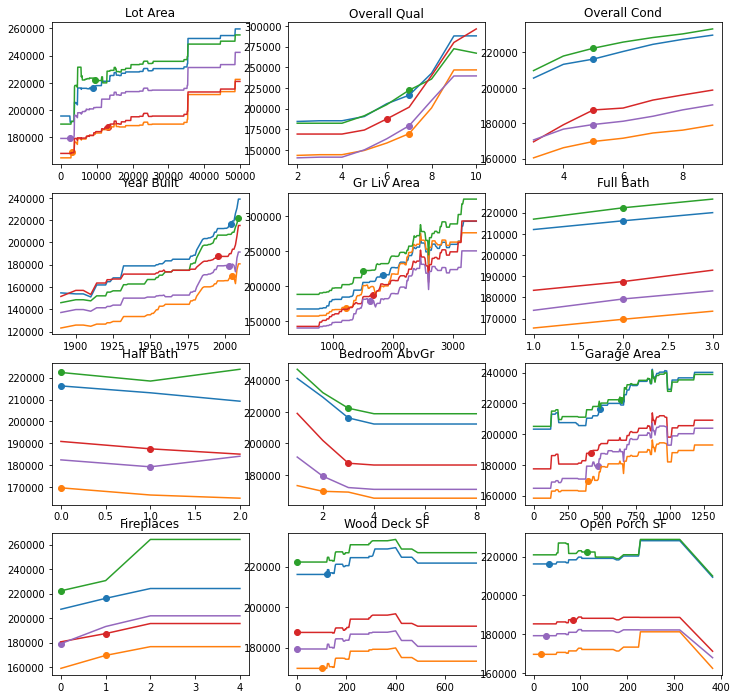

In [26]:
mli.ice_plot(xgb_md3, test_pts_2, X_test_2.columns, range_pts=rd2, pred_fn='predict')

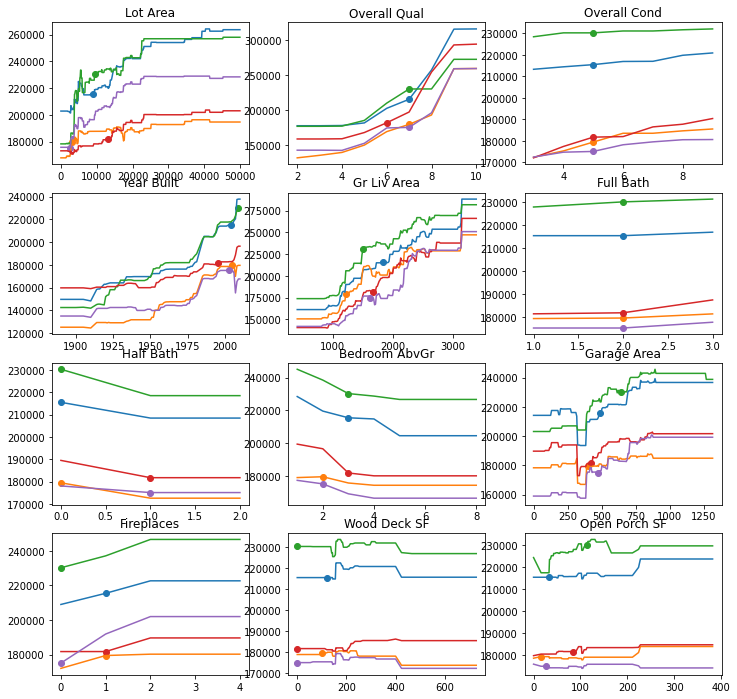

In [27]:
mli.ice_plot(xgb_md6, test_pts_2, X_test_2.columns, range_pts=rd2, pred_fn='predict')

In [28]:
import catboost as cb

In [29]:
feat_3 = ['Lot Area','Overall Qual',
       'Overall Cond', 'Year Built', 'Gr Liv Area', 
        'Full Bath', 'Half Bath', 'Bedroom AbvGr',
         'Garage Area', 'Fireplaces',
          'Wood Deck SF', 'Open Porch SF', 'Neighborhood']

In [30]:
X_train_3 = X_train_full.loc[:, feat_3]
y_train_3 = y_train_full
X_test_3 = X_test.loc[:, feat_3]

In [31]:
## Try md 4 then md 6
cb3 = cb.CatBoostRegressor(n_estimators=10000, learning_rate=.01, max_depth=6,
                          early_stopping_rounds=10, eval_metric='RMSE', cat_features=['Neighborhood'])

cb3.fit(X_train_3, y_train_3, eval_set=[(X_test_3, y_test)], verbose=0)

cb3_preds = cb3.predict(X_test_3)
np.sqrt(mean_squared_error(y_test, cb3_preds))

21669.705521494834

In [32]:
rd3 = mli.get_range_dict(X_train_3)
rd3['Lot Area'] = np.linspace(0,50000,501)
test_pts_3 = X_test_3.sample(5, random_state=1)

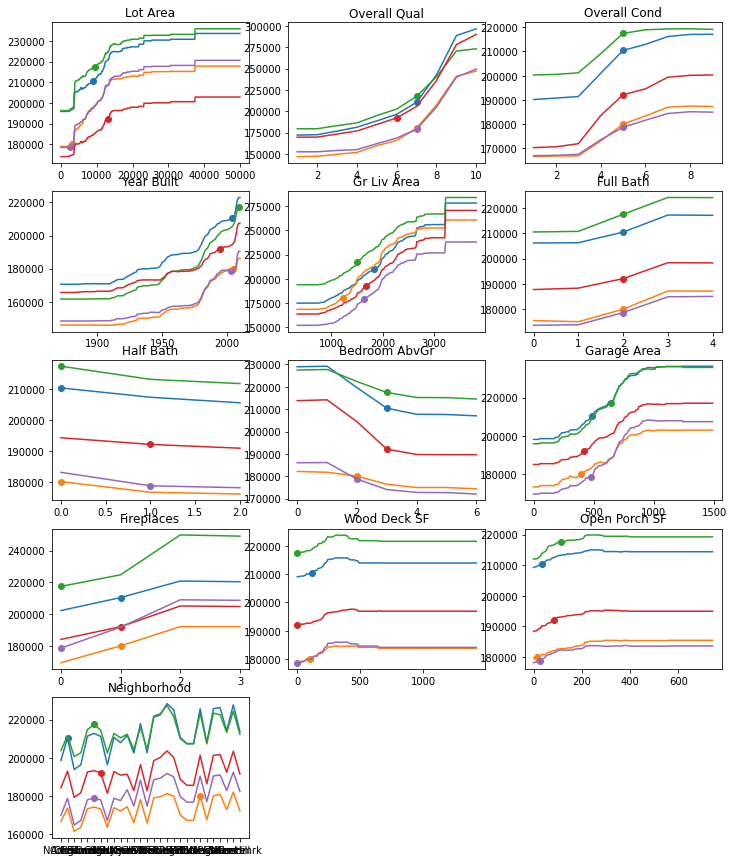

In [33]:
mli.ice_plot(cb3, test_pts_3, X_test_3.columns, range_pts=rd3, pred_fn='predict')

In [34]:
neigh_list = df_house.groupby(['Neighborhood']).SalePrice.mean().sort_values().index
rd3['Neighborhood'] = neigh_list

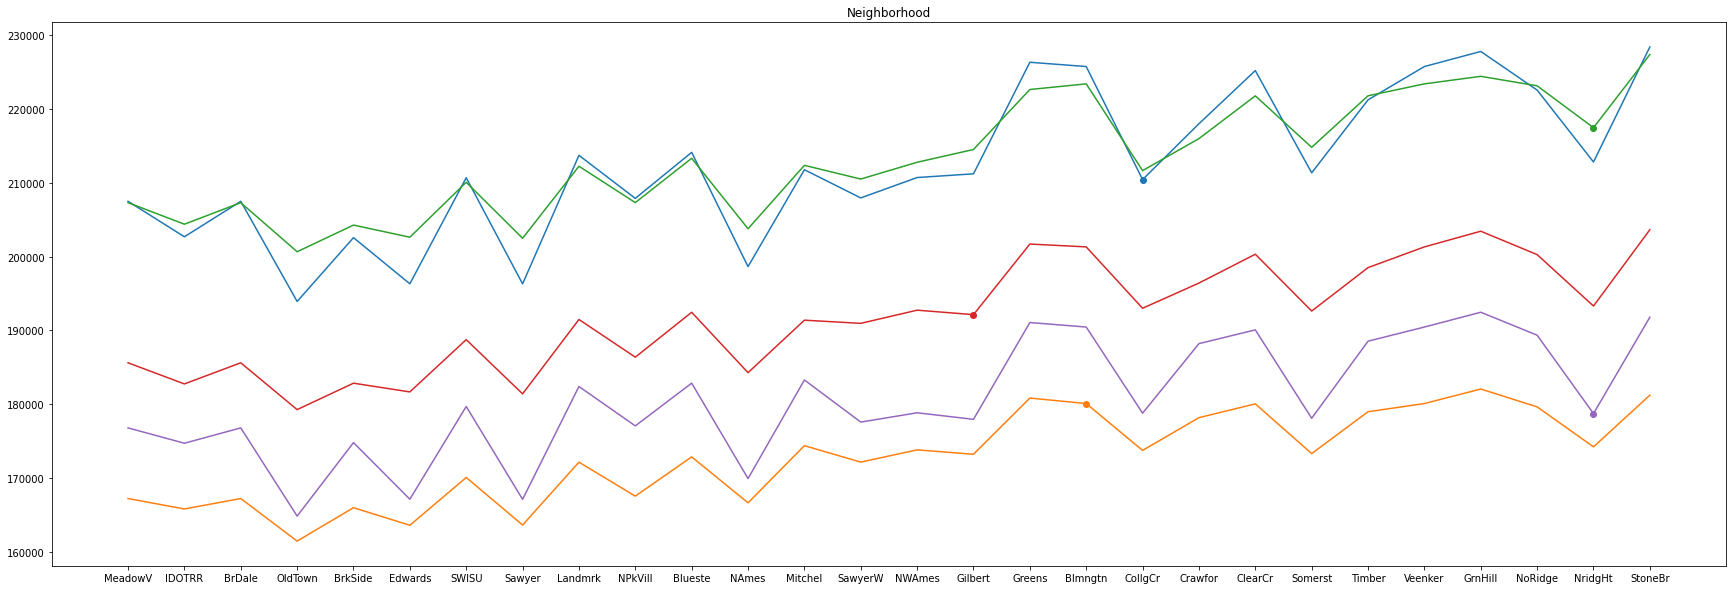

In [35]:
mli.ice_plot(cb3, test_pts_3, 'Neighborhood', range_pts=rd3, pred_fn='predict',
            figsize=(30,10))

## Explaining Individual Predictions with SHAP



- In the previous, we focused our attention to understanding the overall dynamics of the model.

- However, in many cases,  we want to understand the reasons behind a specific prediction.

## Goal: 
- Explain why a particular instance is "different" from average.
- Which features / concepts contributed most to its "distinctiveness"?
- Can we attribute the "distance from average" of a particular case to the individual features?


## SHAP

### Idea: 

- #### arbitrarily order the features $X_1, X_2, \ldots, X_k$.

- #### Compare $E(Y|X_1 = x_1, X_2 = x_2, \ldots, X_{j-1}=x_{j-1})$ to $E(Y|X_1 = x_1, X_2 = x_2, \ldots, X_j=x_j)$ (actually, compare the log odds) and attribute the difference to feature $X_j$ being equal to $x_j$.

- #### Average the "attributions" to a feature over all possible orderings of the features

### This is motivated by the "Shapley Value" in Game Theory 
### Same approach attributes ~98% of the "power" in the Security Council to the 5 permanent members

The "magic" of SHAP is that step (3) (averaging over all possible orderings) is typically computationally prohibitive, but for tree-based models they found a clever way to compute "it" effeciently.

### End Result
Given a particular data point and its prediction, we can assign numerical values to each feature such that the sum of those values represents the distance between the "baseline" average and the predicted value.

### References
*A Unified Approach to Interpreting Model Predictions*
Scott Lundberg, Su-In Lee
https://arxiv.org/abs/1705.07874

*Consistent Individualized Feature Attribution for Tree Ensembles*
Scott M. Lundberg, Gabriel G. Erion, Su-In Lee
https://arxiv.org/abs/1802.03888


### Getting the SHAP values
There are multiple ways to get SHAP values.  The SHAP package has a "TreeExplainer" which works with sklearn, CatBoost, LightGBM, XGBoost.  Additionally, the individual packages have their own methods for getting the values, which vary from package to package.  We will demonstrate both below.

In [36]:
# !pip install shap #if you don't have it installed
import shap

In [37]:
tree_expl_cb3 = shap.TreeExplainer(cb3)
shap_val = tree_expl_cb3(X_test_3)

In [38]:
type(shap_val)

shap._explanation.Explanation

In [39]:
# The shap._explanation.Explanation object has 3 attributes
# .values (the values corresponding to each feature)
# .base_values (the intercept values that we "start" from)
# .data (A copy of the data it was applied to)
# We will take this info and put it into a DataFrame for easier reference
sv_df = pd.DataFrame(shap_val.values, columns=X_test_3.columns)
sv_df['Intercept'] = shap_val.base_values

In [40]:
sv_df.head()

,Lot Area,Overall Qual,Overall Cond,Year Built,Gr Liv Area,Full Bath,Half Bath,Bedroom AbvGr,Garage Area,Fireplaces,Wood Deck SF,Open Porch SF,Neighborhood,Intercept
0,865.522349,-4830.358384,-894.096770,13752.513124,14436.900854,1956.632494,82.972131,-1188.720183,2879.336564,4494.345135,2602.801898,3337.246081,3040.623262,180811.865629
1,-4416.913146,-9339.937030,-12845.878078,-23550.612989,-15677.067594,-2901.506254,-820.404142,-1440.670465,-7737.679752,-7261.478772,-1909.617625,-311.575055,-8864.433143,180811.865629
2,-6914.114137,26429.744944,-460.918765,20296.766220,22723.328516,1693.900074,-7.866719,-1948.002676,28851.101845,5486.579092,3202.837170,-194.123862,2719.779947,180811.865629
3,380.233976,-21908.012895,-1818.244609,-7346.051327,-17782.547924,-2904.712292,-562.470371,1000.391351,-8115.338349,-7019.993460,-1905.762942,-1739.909626,-5597.740427,180811.865629
4,-2468.112310,-22784.225388,7132.487612,-21923.339248,-12379.948569,-3070.527187,-891.700425,-799.949971,-4735.093985,-7573.207145,-1257.551499,-1558.696938,-8370.150114,180811.865629


In [41]:
# Alternate way to get same info in CatBoost directly
shap_values_2 = cb3.get_feature_importance(cb.Pool(X_test_3, cat_features=['Neighborhood']), 
                                                                     type="ShapValues")

sv_df_2 = pd.DataFrame(shap_values_2, columns = list(X_test_3.columns) + ['Intercept'])
np.allclose(sv_df.values, sv_df_2.values)

True

### OK, what do these numbers mean
- For each prediction, we can "decompose" it into a sum of contributions from each feature
- The Intercept represents what we would predict if we knew nothing about the house
- The feature-specific SHAP values represent, (on average) how much (and in what direction) the model "revised its opinion" upon learning that feature value.

Let's walk through an example

In [42]:
np.mean(y_train_2)

180853.18297029703

In [43]:
test_point = 2
np.sum(sv_df.iloc[test_point,:]), cb3_preds[test_point]

(282690.8772778672, 282690.87727786717)

In [44]:
# The values of the features, and the contribution to the final score
pd.concat((X_test_3.iloc[test_point,:], sv_df.iloc[test_point,:-1]), axis=1)

,1797,2
Lot Area,9000,-6914.114137
Overall Qual,8,26429.744944
Overall Cond,5,-460.918765
Year Built,2006,20296.766220
Gr Liv Area,1959,22723.328516
Full Bath,2,1693.900074
Half Bath,1,-7.866719
Bedroom AbvGr,3,-1948.002676
Garage Area,1025.0,28851.101845
Fireplaces,1,5486.579092


#### Force Plot in SHAP

In [45]:
shap.initjs()

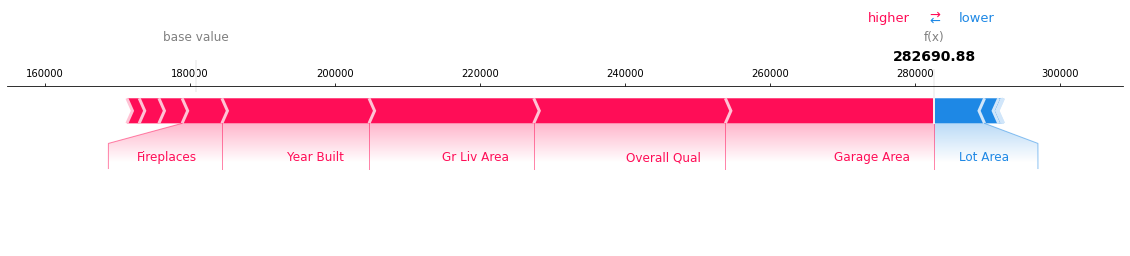

In [46]:
shap.force_plot(tree_expl_cb3.expected_value, sv_df.iloc[test_point,:-1].values, feature_names=X_test_3.columns,matplotlib=True)

### Global importances
One way to get a sense of how "globally" important a feature is to aggregate the (absolute value of) the local feature values.  This can be done easily in Pandas.

The numbers can be thought of as the "average absolute impact" that a variable has on the prediction.


In [47]:
sv_df.abs().mean().sort_values(ascending=False)

Intercept        180811.865629
Gr Liv Area       17487.571211
Overall Qual      15226.906174
Year Built        13559.408521
Fireplaces         7688.834672
Garage Area        7050.994996
Lot Area           6931.038578
Neighborhood       6283.874228
Overall Cond       3401.783300
Full Bath          2853.616442
Wood Deck SF       2218.956556
Open Porch SF      1939.947376
Bedroom AbvGr      1581.388970
Half Bath           621.276104
dtype: float64

In [48]:
def analyze_effect(feature_name, reas_df, test_df, fillna_val=0):
    plt.subplot(2,2,1)
    plt.scatter(test_df[feature_name].fillna(fillna_val), reas_df[feature_name], alpha=.1)
    plt.subplot(2,2,2)
    plt.scatter(reas_df[feature_name], test_df[feature_name].fillna(fillna_val), alpha=.1)
    plt.subplot(2,2,3)
    plt.hist(test_df[feature_name].fillna(fillna_val))
    plt.subplot(2,2,4)
    plt.hist(reas_df[feature_name])


### Looking for interactivity
- we can plot a feature value vs its SHAP value to understand the net average effect of particular values
- The more vertical variation (in the left plot) the more interactivity

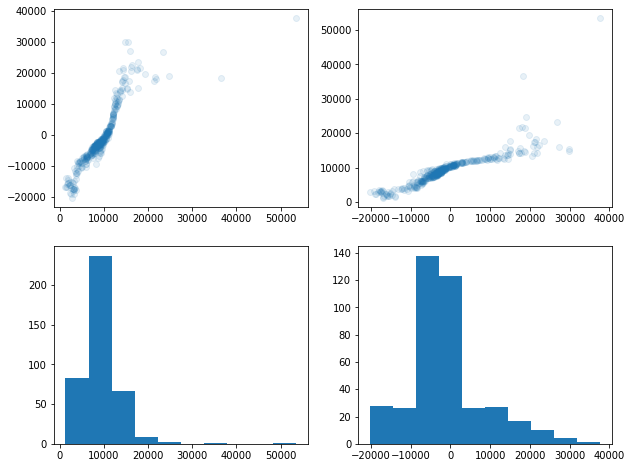

In [49]:
plt.figure(figsize=(10,8))
analyze_effect('Lot Area',sv_df, X_test_3)

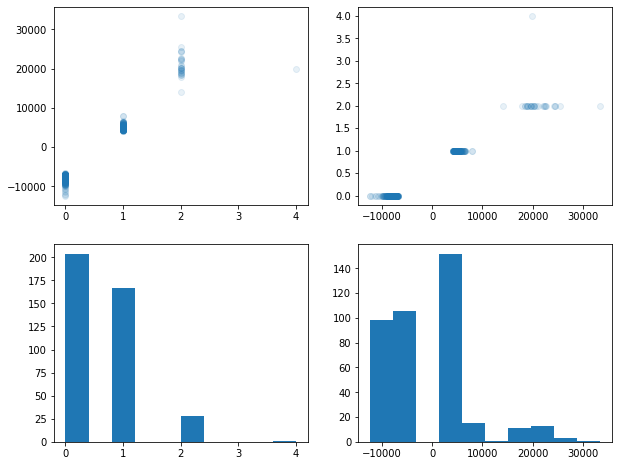

In [50]:
plt.figure(figsize=(10,8))
analyze_effect('Fireplaces',sv_df, X_test_3)

In [51]:
## Look at correlations between the reasons
pd.DataFrame(np.round(np.corrcoef(sv_df.values[:,:-1].T), decimals=2), columns = sv_df.columns[:-1], index = sv_df.columns[:-1])

,Lot Area,Overall Qual,Overall Cond,Year Built,Gr Liv Area,Full Bath,Half Bath,Bedroom AbvGr,Garage Area,Fireplaces,Wood Deck SF,Open Porch SF,Neighborhood
Lot Area,1.00,0.20,0.09,0.06,0.48,0.23,0.07,-0.09,0.34,0.29,0.29,0.18,0.22
Overall Qual,0.20,1.00,0.10,0.55,0.36,0.32,0.32,0.27,0.56,0.30,0.20,0.23,0.56
Overall Cond,0.09,0.10,1.00,-0.04,0.05,-0.06,0.20,0.06,0.05,0.10,-0.01,0.05,0.05
Year Built,0.06,0.55,-0.04,1.00,0.24,0.53,0.26,0.17,0.49,0.15,0.21,0.42,0.70
Gr Liv Area,0.48,0.36,0.05,0.24,1.00,0.54,0.30,-0.22,0.43,0.48,0.38,0.34,0.43
Full Bath,0.23,0.32,-0.06,0.53,0.54,1.00,0.12,-0.14,0.32,0.21,0.28,0.32,0.51
Half Bath,0.07,0.32,0.20,0.26,0.30,0.12,1.00,0.08,0.18,0.33,0.20,0.22,0.32
Bedroom AbvGr,-0.09,0.27,0.06,0.17,-0.22,-0.14,0.08,1.00,0.11,0.08,-0.10,-0.07,0.12
Garage Area,0.34,0.56,0.05,0.49,0.43,0.32,0.18,0.11,1.00,0.23,0.20,0.24,0.40
Fireplaces,0.29,0.30,0.10,0.15,0.48,0.21,0.33,0.08,0.23,1.00,0.29,0.13,0.34


### Exercise
- Train a CatBoost model using the features below.
- Make ICE plots for all variables
- Get the SHAP values for the predictions
- How did the addition of the new variables impact the other variables in the model.
- Find cases where the new model had a very different prediction than the old model and compare the SHAP values.

In [52]:
feat_4 = ['Lot Area','Overall Qual',
       'Overall Cond', 'Year Built', 'Gr Liv Area', 
        'Full Bath', 'Half Bath', 'Bedroom AbvGr',
         'Garage Area', 'Fireplaces',
          'Wood Deck SF', 'Open Porch SF', 'Neighborhood',
          'Bsmt Unf SF', 'Total Bsmt SF']